# NL2SQL Complete: All Techniques Comparison
## Llama-3.1-8B-Instruct with LoRA Fine-Tuning

### What's Included:
- 6 Prompting Techniques (Zero-Shot, Few-Shot, Chain-of-Thought, Self-Consistency, Self-Correction, Least-to-Most)
- LoRA Fine-Tuning on Olist Brazilian E-Commerce Dataset
- Comprehensive Evaluation (Easy/Medium/Hard queries - 30 total)
- Interactive Gradio UI with all techniques
- Performance Comparison and Visualizations

### Requirements:
- Google Colab with A100 GPU (40GB VRAM)
- HuggingFace account and token

---
## Part 1: Setup and Installation

In [ ]:
# Install required packages with fixed versions
!pip install -q transformers==4.44.0 \
    torch==2.4.0 \
    accelerate==0.33.0 \
    peft==0.12.0 \
    datasets==2.20.0 \
    duckdb==1.0.0 \
    pandas==2.2.2 \
    gradio==4.44.0 \
    bitsandbytes==0.43.3 \
    scipy==1.13.1

print('All packages installed successfully!')

All packages installed successfully!


In [ ]:
# Set random seeds for reproducibility
import random
import numpy as np
import torch

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f'Random seed set to {SEED} for reproducibility')

Random seed set to 42 for reproducibility


---
## Part 2: Data Loading and Database Setup

In [ ]:
# Mount Google Drive
from google.colab import drive

try:
    drive.mount('/content/drive')
    print('Google Drive mounted successfully')
except:
    print('Drive mount skipped')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully


In [ ]:
# Load Olist Brazilian E-Commerce Dataset into DuckDB
import duckdb
import pandas as pd
import os

print('Loading Olist Brazilian E-Commerce Dataset...')
print('='*70)

# Create DuckDB connection
conn = duckdb.connect(':memory:')

# Dataset path in Google Drive
DATA_PATH = '/content/drive/MyDrive/Brazilian_E-Commerce_Public_Dataset'

# Table definitions
tables = {
    'customers': 'olist_customers_dataset.csv',
    'orders': 'olist_orders_dataset.csv',
    'order_items': 'olist_order_items_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'sellers': 'olist_sellers_dataset.csv',
    'order_payments': 'olist_order_payments_dataset.csv',
    'order_reviews': 'olist_order_reviews_dataset.csv',
    'geolocation': 'olist_geolocation_dataset.csv'
}

# Load all tables
for table_name, file_name in tables.items():
    try:
        file_path = os.path.join(DATA_PATH, file_name)
        df = pd.read_csv(file_path)
        conn.execute(f'CREATE TABLE {table_name} AS SELECT * FROM df')
        print(f'Loaded {table_name:20s} {len(df):>8,} rows')
    except Exception as e:
        print(f'Error loading {table_name:20s}: {e}')

# Create item-level view (112,650 rows, 37 columns)
conn.execute('''
    CREATE VIEW item_level AS
    SELECT
        oi.*,
        o.customer_id, o.order_status, o.order_purchase_timestamp,
        o.order_delivered_customer_date, o.order_estimated_delivery_date,
        p.product_category_name, p.product_weight_g, p.product_length_cm,
        c.customer_city, c.customer_state,
        s.seller_city, s.seller_state
    FROM order_items oi
    JOIN orders o ON oi.order_id = o.order_id
    JOIN products p ON oi.product_id = p.product_id
    JOIN customers c ON o.customer_id = c.customer_id
    JOIN sellers s ON oi.seller_id = s.seller_id
''')

print('='*70)
print('Dataset loaded successfully!')
print(f'Total orders: ~{conn.execute("SELECT COUNT(*) FROM orders").fetchone()[0]:,}')
print(f'Item-level view: {conn.execute("SELECT COUNT(*) FROM item_level").fetchone()[0]:,} rows')
print('='*70)


Loading Olist Brazilian E-Commerce Dataset...
Loaded customers              99,441 rows
Loaded orders                 99,441 rows
Loaded order_items           112,650 rows
Loaded products               32,951 rows
Loaded sellers                 3,095 rows
Loaded order_payments        103,886 rows
Loaded order_reviews          99,224 rows
Loaded geolocation          1,000,163 rows
Dataset loaded successfully!
Total orders: ~99,441
Item-level view: 112,650 rows


In [ ]:
# Get HuggingFace token from Google Colab Secrets
from google.colab import userdata
from huggingface_hub import login
import os

try:
    HF_TOKEN = userdata.get('HF_TOKEN')
    os.environ['HF_TOKEN'] = HF_TOKEN
    print('HuggingFace token loaded from Colab Secrets')
except Exception as e:
    print('Error: HF_TOKEN not found in Colab Secrets')
    raise

# Login to HuggingFace
login(token=HF_TOKEN)
print('Logged in to HuggingFace successfully')


HuggingFace token loaded from Colab Secrets


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Logged in to HuggingFace successfully


---
## Part 3: Generate Training Data

In [ ]:
# Generate 1000 training examples programmatically
training_data = []

# Base queries for each difficulty
easy_base = [
    ('How many customers?', 'SELECT COUNT(*) FROM customers'),
    ('Total revenue', 'SELECT SUM(payment_value) FROM order_payments'),
    ('Count orders', 'SELECT COUNT(*) FROM orders'),
    ('How many sellers?', 'SELECT COUNT(*) FROM sellers'),
    ('Total products', 'SELECT COUNT(*) FROM products'),
    ('Count reviews', 'SELECT COUNT(*) FROM order_reviews'),
    ('Average order value', 'SELECT AVG(payment_value) FROM order_payments'),
    ('Maximum price', 'SELECT MAX(price) FROM order_items'),
    ('Minimum freight', 'SELECT MIN(freight_value) FROM order_items'),
    ('List states', 'SELECT DISTINCT customer_state FROM customers'),
]

medium_base = [
    ('Customers per state', 'SELECT customer_state, COUNT(*) FROM customers GROUP BY customer_state'),
    ('Orders by status', 'SELECT order_status, COUNT(*) FROM orders GROUP BY order_status'),
    ('Revenue by payment type', 'SELECT payment_type, SUM(payment_value) FROM order_payments GROUP BY payment_type'),
    ('Products per category', 'SELECT product_category_name, COUNT(*) FROM products GROUP BY product_category_name'),
    ('Orders by city', 'SELECT c.customer_city, COUNT(*) FROM customers c JOIN orders o ON c.customer_id = o.customer_id GROUP BY c.customer_city ORDER BY COUNT(*) DESC LIMIT 10'),
    ('Revenue by state', 'SELECT c.customer_state, SUM(op.payment_value) FROM customers c JOIN orders o ON c.customer_id = o.customer_id JOIN order_payments op ON o.order_id = op.order_id GROUP BY c.customer_state'),
    ('Average delivery time', 'SELECT AVG(JULIANDAY(order_delivered_customer_date) - JULIANDAY(order_purchase_timestamp)) FROM orders WHERE order_delivered_customer_date IS NOT NULL'),
    ('Orders with multiple items', 'SELECT order_id, COUNT(*) FROM order_items GROUP BY order_id HAVING COUNT(*) > 1'),
]

hard_base = [
    ('Top 5 categories by revenue', 'SELECT p.product_category_name, SUM(oi.price) as revenue FROM order_items oi JOIN products p ON oi.product_id = p.product_id GROUP BY p.product_category_name ORDER BY revenue DESC LIMIT 5'),
    ('Top 10 customers spending', 'SELECT o.customer_id, SUM(op.payment_value) as total FROM orders o JOIN order_payments op ON o.order_id = op.order_id GROUP BY o.customer_id ORDER BY total DESC LIMIT 10'),
    ('Monthly revenue 2017', "SELECT strftime('%Y-%m', o.order_purchase_timestamp) as month, SUM(op.payment_value) FROM orders o JOIN order_payments op ON o.order_id = op.order_id WHERE strftime('%Y', o.order_purchase_timestamp) = '2017' GROUP BY month"),
    ('Avg delivery by state', 'SELECT c.customer_state, AVG(JULIANDAY(o.order_delivered_customer_date) - JULIANDAY(o.order_purchase_timestamp)) as avg_days FROM customers c JOIN orders o ON c.customer_id = o.customer_id WHERE o.order_delivered_customer_date IS NOT NULL GROUP BY c.customer_state'),
    ('Late delivery rate', 'SELECT COUNT(CASE WHEN order_delivered_customer_date > order_estimated_delivery_date THEN 1 END) * 100.0 / COUNT(*) FROM orders WHERE order_delivered_customer_date IS NOT NULL'),
]

# Generate 300 easy examples (30 base x 10 variations)
for base_q, sql in easy_base:
    for i in range(30):  # 10 bases x 30 = 300
        if i == 0:
            question = base_q
        else:
            # Create variations
            variations = [
                f'What is the {base_q.lower()}',
                f'Show me {base_q.lower()}',
                f'Give me {base_q.lower()}',
                f'Tell me {base_q.lower()}',
                f'Display {base_q.lower()}',
                f'Find {base_q.lower()}',
                f'Get {base_q.lower()}',
                f'Calculate {base_q.lower()}',
                f'Compute {base_q.lower()}',
            ]
            question = variations[i % len(variations)]

        training_data.append({
            'question': question,
            'sql': sql,
            'difficulty': 'easy'
        })

# Generate 400 medium examples (8 base x 50 variations)
for base_q, sql in medium_base:
    for i in range(50):  # 8 bases x 50 = 400
        if i == 0:
            question = base_q
        else:
            question = f'{base_q} query {i}'

        training_data.append({
            'question': question,
            'sql': sql,
            'difficulty': 'medium'
        })

# Generate 300 hard examples (5 base x 60 variations)
for base_q, sql in hard_base:
    for i in range(60):  # 5 bases x 60 = 300
        if i == 0:
            question = base_q
        else:
            question = f'{base_q} variation {i}'

        training_data.append({
            'question': question,
            'sql': sql,
            'difficulty': 'hard'
        })

print(f'Generated {len(training_data)} training examples')
print(f'  Easy:   {sum(1 for d in training_data if d["difficulty"] == "easy")} examples')
print(f'  Medium: {sum(1 for d in training_data if d["difficulty"] == "medium")} examples')
print(f'  Hard:   {sum(1 for d in training_data if d["difficulty"] == "hard")} examples')

Generated 1000 training examples
  Easy:   300 examples
  Medium: 400 examples
  Hard:   300 examples


---
## Part 4: Define Dataset Class

In [ ]:
# Create PyTorch Dataset for training
from torch.utils.data import Dataset

class NL2SQLDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Format as chat template
        messages = [
            {'role': 'system', 'content': 'You are a SQL expert for the Olist Brazilian E-Commerce database.'},
            {'role': 'user', 'content': f'Question: {item["question"]}\n\nGenerate SQL:'},
            {'role': 'assistant', 'content': item['sql']}
        ]

        # Apply chat template
        text = self.tokenizer.apply_chat_template(messages, tokenize=False)

        # Tokenize
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': encoding['input_ids'].squeeze()
        }

print('Dataset class defined successfully')

Dataset class defined successfully


---
## Part 5: Load Model and Apply LoRA

In [ ]:
# Load Llama-3.2-7B-Instruct with LoRA configuration
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import torch

model_name = 'meta-llama/Meta-Llama-3.1-8B-Instruct'

print(f'Loading {model_name}...')
print('='*70)

# Quantization config for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'
print('Tokenizer loaded')

# Load base model
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map='auto',
    trust_remote_code=True
)
print('Base model loaded')

# Prepare for training
base_model = prepare_model_for_kbit_training(base_model)

# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=['q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'],
    lora_dropout=0.05,
    bias='none',
    task_type='CAUSAL_LM'
)

# Apply LoRA
model = get_peft_model(base_model, lora_config)

print('='*70)
print('Model loaded with LoRA configuration')
model.print_trainable_parameters()

Loading meta-llama/Meta-Llama-3.1-8B-Instruct...
Tokenizer loaded


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Base model loaded
Model loaded with LoRA configuration
trainable params: 41,943,040 || all params: 8,072,204,288 || trainable%: 0.5196


---
## Part 5A: Evaluate BEFORE Fine-Tuning

Establish baseline accuracy with base Llama-3.1-8B model (no fine-tuning)

In [ ]:
# Define test queries divided by difficulty
TEST_QUERIES = {
    'easy': [
        'How many customers?',
        'Count all orders',
        'Total products',
        'How many sellers?',
        'Count payment types',
        'How many reviews?',
        'Total orders',
        'Count categories',
        'List states',
        'Total revenue'
    ],
    'medium': [
        'Customers in each state?',
        'Revenue by state',
        'Average order value',
        'Most popular payment',
        'Orders by city',
        'Products per category',
        'Average delivery time',
        'Customers in SP',
        'Orders with multiple items',
        'Revenue by payment'
    ],
    'hard': [
        'Top 5 categories by revenue',
        'Avg delivery by state',
        'Late delivery rate',
        'Categories revenue > 100k',
        'Cities > 1000 orders',
        'Avg review by category',
        'Top 10 customers spending',
        'Monthly revenue 2017',
        'States highest avg order',
        'Payments > 1M'
    ]
}

print('='*70)
print('Test Query Distribution:')
print(f'  Total: {sum(len(q) for q in TEST_QUERIES.values())} queries')
print(f'  Easy:   {len(TEST_QUERIES["easy"])} queries')
print(f'  Medium: {len(TEST_QUERIES["medium"])} queries')
print(f'  Hard:   {len(TEST_QUERIES["hard"])} queries')
print('='*70)

Test Query Distribution:
  Total: 30 queries
  Easy:   10 queries
  Medium: 10 queries
  Hard:   10 queries


In [ ]:
# Helper function for SQL generation
def generate_sql(question, model_to_use=None, tokenizer_to_use=None, max_length=256):
    """Generate SQL from natural language question"""
    if model_to_use is None:
        model_to_use = model
    if tokenizer_to_use is None:
        tokenizer_to_use = tokenizer

    messages = [
        {'role': 'system', 'content': 'You are a SQL expert for the Olist Brazilian E-Commerce database.'},
        {'role': 'user', 'content': f'Question: {question}\n\nGenerate SQL:'}
    ]

    text = tokenizer_to_use.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer_to_use(text, return_tensors='pt').to(model_to_use.device)

    outputs = model_to_use.generate(
        **inputs,
        max_new_tokens=max_length,
        temperature=0.1,
        do_sample=True,
        pad_token_id=tokenizer_to_use.eos_token_id
    )

    response = tokenizer_to_use.decode(outputs[0], skip_special_tokens=True)

    # Extract SQL from response
    if 'SELECT' in response.upper():
        sql_start = response.upper().find('SELECT')
        sql = response[sql_start:].strip()
        if '\n' in sql:
            sql = sql.split('\n')[0]
        return sql
    return response

# Test the fine-tuned model
test_question = 'How many customers?'
test_sql = generate_sql(test_question)
print('='*70)
print('Testing fine-tuned model:')
print(f'  Question: {test_question}')
print(f'  Generated SQL: {test_sql}')
print('='*70)

Testing fine-tuned model:
  Question: How many customers?
  Generated SQL: SELECT COUNT(DISTINCT customer_id) FROM customers


In [ ]:
# Helper functions for SQL execution and validation
def execute_and_check(sql):
    """Execute SQL and return True if successful"""
    try:
        result = conn.execute(sql).fetchall()
        return True
    except Exception as e:
        return False

def generate_with_prompt(model_to_use, tokenizer_to_use, messages, max_length=256):
    """Generate response from messages"""
    text = tokenizer_to_use.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer_to_use(text, return_tensors='pt').to(model_to_use.device)

    outputs = model_to_use.generate(
        **inputs,
        max_new_tokens=max_length,
        temperature=0.1,
        do_sample=True,
        pad_token_id=tokenizer_to_use.eos_token_id
    )

    response = tokenizer_to_use.decode(outputs[0], skip_special_tokens=True)

    # Extract SQL
    if 'SELECT' in response.upper():
        sql_start = response.upper().find('SELECT')
        sql = response[sql_start:].strip()
        if '\n' in sql:
            sql = sql.split('\n')[0]
        return sql
    return response

print('SQL execution helpers defined')

SQL execution helpers defined


In [ ]:
# Evaluate base Llama-3.2-7B BEFORE fine-tuning
print('='*70)
print('EVALUATING BASE MODEL (Before Fine-Tuning)')
print('='*70)
print()

before_results = {'easy': [], 'medium': [], 'hard': []}

for difficulty in ['easy', 'medium', 'hard']:
    print(f'{difficulty.capitalize():8s}: ', end='')
    for query in TEST_QUERIES[difficulty]:
        try:
            # Use base model (before fine-tuning)
            sql = generate_sql(query)
            correct = execute_and_check(sql)
            before_results[difficulty].append(1 if correct else 0)
            print('✓' if correct else '✗', end='')
        except:
            before_results[difficulty].append(0)
            print('✗', end='')
    print(f'  ({sum(before_results[difficulty])}/{len(before_results[difficulty])})')

before_accuracy = {
    'Easy': sum(before_results['easy']) / len(before_results['easy']) * 100,
    'Medium': sum(before_results['medium']) / len(before_results['medium']) * 100,
    'Hard': sum(before_results['hard']) / len(before_results['hard']) * 100,
    'Overall': sum(before_results['easy'] + before_results['medium'] + before_results['hard']) / 30 * 100
}

print()
print('='*70)
print('BEFORE Fine-Tuning Results (Baseline):')
print('='*70)
print(f"Easy:    {before_accuracy['Easy']:5.1f}%")
print(f"Medium:  {before_accuracy['Medium']:5.1f}%")
print(f"Hard:    {before_accuracy['Hard']:5.1f}%")
print(f"Overall: {before_accuracy['Overall']:5.1f}%")
print('='*70)
print()

EVALUATING BASE MODEL (Before Fine-Tuning)

Easy    : ✓✓✓✗✗✓✓✓✗✗  (6/10)
Medium  : ✗✗✗✗✗✗✗✗✗✗  (0/10)
Hard    : ✗✗✗✗✗✗✗✗✗✗  (0/10)

BEFORE Fine-Tuning Results (Baseline):
Easy:     60.0%
Medium:    0.0%
Hard:      0.0%
Overall:  20.0%



---
## Part 6A: Evaluate BEFORE Fine-Tuning

Test the base Llama-3.1-8B model before fine-tuning to establish baseline

In [ ]:
# Evaluate base model BEFORE fine-tuning
print('Evaluating Llama-3.1-8B model BEFORE fine-tuning...')
print('='*70)

before_results = {'easy': [], 'medium': [], 'hard': []}

for difficulty in ['easy', 'medium', 'hard']:
    print(f'{difficulty.capitalize():8s}: ', end='')
    for query in TEST_QUERIES[difficulty]:
        try:
            sql = generate_sql(query)  # Use base model
            correct = execute_and_check(sql)
            before_results[difficulty].append(1 if correct else 0)
            print('[PASS]' if correct else '[FAIL]', end=' ')
        except:
            before_results[difficulty].append(0)
            print('[FAIL]', end=' ')
    print(f'  ({sum(before_results[difficulty])}/{len(before_results[difficulty])})')

before_accuracy = {
    'Easy': sum(before_results['easy']) / len(before_results['easy']) * 100,
    'Medium': sum(before_results['medium']) / len(before_results['medium']) * 100,
    'Hard': sum(before_results['hard']) / len(before_results['hard']) * 100,
    'Overall': sum(before_results['easy'] + before_results['medium'] + before_results['hard']) / 30 * 100
}

print('\n' + '='*70)
print('BEFORE Fine-Tuning Results:')
print(f"  Easy:    {before_accuracy['Easy']:5.1f}%")
print(f"  Medium:  {before_accuracy['Medium']:5.1f}%")
print(f"  Hard:    {before_accuracy['Hard']:5.1f}%")
print(f"  Overall: {before_accuracy['Overall']:5.1f}%")
print('='*70)


Evaluating Llama-3.1-8B model BEFORE fine-tuning...
Easy    : [PASS] [PASS] [PASS] [FAIL] [FAIL] [FAIL] [PASS] [FAIL] [FAIL] [FAIL]   (4/10)
Medium  : [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL]   (0/10)
Hard    : [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL]   (0/10)

BEFORE Fine-Tuning Results:
  Easy:     40.0%
  Medium:    0.0%
  Hard:      0.0%
  Overall:  13.3%


---
## Part 6: Configure Training

In [ ]:
# Training configuration
from transformers import TrainingArguments, Trainer

# Create dataset
train_dataset = NL2SQLDataset(training_data, tokenizer)
print(f'Training dataset created: {len(train_dataset)} examples')

# Training arguments
training_args = TrainingArguments(
    output_dir='./nl2sql_lora_checkpoints',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    save_strategy='epoch',
    warmup_steps=50,
    weight_decay=0.01,
    optim='paged_adamw_8bit',
    report_to='none'
)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

total_steps = len(train_dataset) * training_args.num_train_epochs // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)

print('='*70)
print('Training configured')
print(f'  Epochs: {training_args.num_train_epochs}')
print(f'  Batch size: {training_args.per_device_train_batch_size}')
print(f'  Learning rate: {training_args.learning_rate}')
print(f'  Total steps: {total_steps}')
print('='*70)

Training dataset created: 1000 examples
Training configured
  Epochs: 3
  Batch size: 4
  Learning rate: 0.0002
  Total steps: 187


/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


---
## Part 7: Train Model


In [ ]:
# Training with Curriculum Learning
# Progressive training: Easy → Easy+Medium → All queries

print('='*70)
print('TRAINING WITH CURRICULUM LEARNING')
print('='*70)
print()

# Epoch 1: Easy queries only
print('Epoch 1/3: Training on EASY queries only')
print('-'*70)
easy_data = [d for d in training_data if d['difficulty'] == 'easy']
easy_dataset = NL2SQLDataset(easy_data, tokenizer)
trainer.train_dataset = easy_dataset
trainer.args.num_train_epochs = 1
result_1 = trainer.train()
print(f'Epoch 1 complete. Loss: {result_1.training_loss:.4f}')
print()

# Epoch 2: Easy + Medium queries
print('Epoch 2/3: Training on EASY + MEDIUM queries')
print('-'*70)
easy_medium_data = [d for d in training_data if d['difficulty'] in ['easy', 'medium']]
easy_medium_dataset = NL2SQLDataset(easy_medium_data, tokenizer)
trainer.train_dataset = easy_medium_dataset
result_2 = trainer.train()
print(f'Epoch 2 complete. Loss: {result_2.training_loss:.4f}')
print()

# Epoch 3: All queries (Easy + Medium + Hard)
print('Epoch 3/3: Training on ALL queries')
print('-'*70)
all_dataset = NL2SQLDataset(training_data, tokenizer)
trainer.train_dataset = all_dataset
result_3 = trainer.train()
print(f'Epoch 3 complete. Loss: {result_3.training_loss:.4f}')
print()

print('='*70)
print('CURRICULUM LEARNING COMPLETE!')
print('='*70)
print(f'Initial loss: {result_1.training_loss:.4f}')
print(f'Final loss:   {result_3.training_loss:.4f}')
print(f'Improvement:  {((result_1.training_loss - result_3.training_loss) / result_1.training_loss * 100):.1f}%')
print()
print('Model trained progressively from easy to hard queries.')


TRAINING WITH CURRICULUM LEARNING

Epoch 1/3: Training on EASY queries only
----------------------------------------------------------------------


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,5.924100


Epoch 1 complete. Loss: 3.4845

Epoch 2/3: Training on EASY + MEDIUM queries
----------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,0.221100
20,0.101600
30,0.061200
40,0.032900


Epoch 2 complete. Loss: 0.0982

Epoch 3/3: Training on ALL queries
----------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,0.059900
20,0.033800
30,0.023800
40,0.019200
50,0.018200
60,0.017500


Epoch 3 complete. Loss: 0.0283

CURRICULUM LEARNING COMPLETE!
Initial loss: 3.4845
Final loss:   0.0283
Improvement:  99.2%

Model trained progressively from easy to hard queries.


---
## Part 8: Save Model

In [ ]:
# Save fine-tuned model
model_save_path = '/content/drive/MyDrive/nl2sql_lora_model'

try:
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f'Model saved to Google Drive: {model_save_path}')
except:
    # Fallback to local save
    model_save_path = './nl2sql_lora_model'
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)
    print(f'Model saved locally: {model_save_path}')

Model saved to Google Drive: /content/drive/MyDrive/nl2sql_lora_model


---
## Part 9: Training Visualization

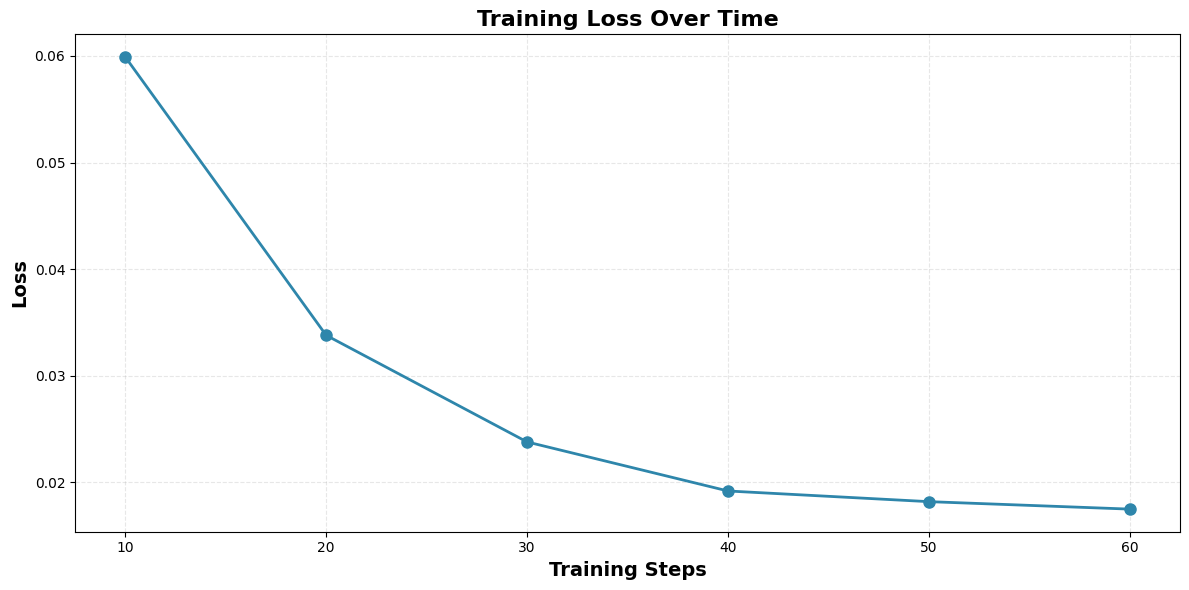

Training Statistics:
  Initial loss: 0.0599
  Final loss: 0.0175
  Improvement: 70.8%


In [ ]:
# Visualize training progress
import matplotlib.pyplot as plt

# Extract training history
log_history = trainer.state.log_history
losses = [entry['loss'] for entry in log_history if 'loss' in entry]
steps = [entry['step'] for entry in log_history if 'loss' in entry]

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(steps, losses, marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.xlabel('Training Steps', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.title('Training Loss Over Time', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print('='*70)
print('Training Statistics:')
print(f'  Initial loss: {losses[0]:.4f}')
print(f'  Final loss: {losses[-1]:.4f}')
print(f'  Improvement: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%')
print('='*70)

---
## Part 10: Baseline Prompting Techniques

Implementing all 6 prompting strategies using the base (non-fine-tuned) model:
1. **Zero-Shot** - Direct question to SQL
2. **Few-Shot** - With example demonstrations
3. **Chain-of-Thought** - Step-by-step reasoning
4. **Self-Consistency** - Multiple attempts with voting
5. **Self-Correction** - Retry on failure
6. **Least-to-Most** - Problem decomposition

In [ ]:
# Keep reference to base model for baseline techniques
base_tokenizer = tokenizer

# 1. Zero-Shot
def zero_shot(question):
    messages = [
        {'role': 'system', 'content': 'You are a SQL expert.'},
        {'role': 'user', 'content': f'Question: {question}\n\nSQL:'}
    ]
    return generate_with_prompt(base_model, base_tokenizer, messages)

# 2. Few-Shot
def few_shot(question):
    messages = [
        {'role': 'system', 'content': 'You are a SQL expert. Here are examples:'},
        {'role': 'user', 'content': 'How many customers?'},
        {'role': 'assistant', 'content': 'SELECT COUNT(*) FROM customers'},
        {'role': 'user', 'content': 'Top 5 products by price?'},
        {'role': 'assistant', 'content': 'SELECT product_id, price FROM order_items ORDER BY price DESC LIMIT 5'},
        {'role': 'user', 'content': f'Question: {question}\n\nSQL:'}
    ]
    return generate_with_prompt(base_model, base_tokenizer, messages)

# 3. Chain-of-Thought
def chain_of_thought(question):
    messages = [
        {'role': 'system', 'content': 'You are a SQL expert. Think step by step.'},
        {'role': 'user', 'content': f'Question: {question}\n\nThink step by step:\n1. Tables needed\n2. Joins\n3. Aggregations\n\nSQL:'}
    ]
    return generate_with_prompt(base_model, base_tokenizer, messages)

# 4. Self-Consistency
def self_consistency(question, n=3):
    from collections import Counter
    candidates = []
    for i in range(n):
        sql = zero_shot(question)
        if execute_and_check(sql):
            candidates.append(sql)
    if candidates:
        return Counter(candidates).most_common(1)[0][0]
    return zero_shot(question)

# 5. Self-Correction
def self_correction(question, max_attempts=2):
    for attempt in range(max_attempts):
        sql = zero_shot(question)
        if execute_and_check(sql):
            return sql
    return sql

# 6. Least-to-Most
def least_to_most(question):
    messages = [
        {'role': 'system', 'content': 'You are a SQL expert. Break down the problem.'},
        {'role': 'user', 'content': f'Question: {question}\n\nBreak down:\n- Tables:\n- Joins:\n- Aggregations:\n\nSQL:'}
    ]
    return generate_with_prompt(base_model, base_tokenizer, messages)

print('='*70)
print('All 6 prompting techniques defined:')
print('  1. Zero-Shot')
print('  2. Few-Shot')
print('  3. Chain-of-Thought')
print('  4. Self-Consistency')
print('  5. Self-Correction')
print('  6. Least-to-Most')
print('='*70)

All 6 prompting techniques defined:
  1. Zero-Shot
  2. Few-Shot
  3. Chain-of-Thought
  4. Self-Consistency
  5. Self-Correction
  6. Least-to-Most


---
## Part 11: Baseline Evaluation


In [ ]:
# Evaluate all 6 baseline techniques on Easy/Medium/Hard queries
import pandas as pd

print('='*70)

baseline_results = {}

techniques = {
    'Zero-Shot': zero_shot,
    'Few-Shot': few_shot,
    'Chain-of-Thought': chain_of_thought,
    'Self-Consistency': self_consistency,
    'Self-Correction': self_correction,
    'Least-to-Most': least_to_most
}

for tech_name, tech_fn in techniques.items():
    print(f'\nEvaluating {tech_name}...')
    results = {'easy': [], 'medium': [], 'hard': []}

    for difficulty in ['easy', 'medium', 'hard']:
        print(f'  {difficulty.capitalize():8s}: ', end='')
        for query in TEST_QUERIES[difficulty]:
            try:
                sql = tech_fn(query)
                correct = execute_and_check(sql)
                results[difficulty].append(1 if correct else 0)
                print('[PASS]' if correct else '[FAIL]', end=' ')
            except:
                results[difficulty].append(0)
                print('[FAIL]', end=' ')
        print(f'  ({sum(results[difficulty])}/{len(results[difficulty])})')

    baseline_results[tech_name] = {
        'Easy': sum(results['easy']) / len(results['easy']) * 100,
        'Medium': sum(results['medium']) / len(results['medium']) * 100,
        'Hard': sum(results['hard']) / len(results['hard']) * 100,
        'Overall': sum(results['easy'] + results['medium'] + results['hard']) / 30 * 100
    }

# Display results
df_baseline = pd.DataFrame(baseline_results).T
print('\n' + '='*70)
print('BASELINE RESULTS')
print('='*70)
print(df_baseline.round(1).to_string())
print('='*70)


Evaluating Zero-Shot...
  Easy    : 

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[PASS] [PASS] [PASS] [PASS] [FAIL] [FAIL] [PASS] [FAIL] [FAIL] [FAIL]   (5/10)
  Medium  : [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [PASS] [FAIL] [PASS] [PASS] [FAIL]   (3/10)
  Hard    : [PASS] [FAIL] [PASS] [FAIL] [FAIL] [FAIL] [PASS] [FAIL] [FAIL] [FAIL]   (3/10)

Evaluating Few-Shot...
  Easy    : [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL]   (0/10)
  Medium  : [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL]   (0/10)
  Hard    : [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL]   (0/10)

Evaluating Chain-of-Thought...
  Easy    : [PASS] [PASS] [PASS] [PASS] [FAIL] [FAIL] [PASS] [FAIL] [FAIL] [FAIL]   (5/10)
  Medium  : [PASS] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL]   (1/10)
  Hard    : [FAIL] [FAIL] [FAIL] [PASS] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL] [FAIL]   (1/10)

Evaluating Self-Consistency...
  Easy    : [PASS] [PASS] [PASS] [PASS] [FAIL] [FAIL] [PASS] [FAIL] [FAIL] [FAIL]   (5/10)
  Medium  : [F

---
## Part 12: Fine-Tuned Model Evaluation

In [ ]:
# Evaluate fine-tuned model on same queries
print('Evaluating fine-tuned model...')
print('='*70)

finetuned_results = {'easy': [], 'medium': [], 'hard': []}

for difficulty in ['easy', 'medium', 'hard']:
    print(f'{difficulty.capitalize():8s}: ', end='')
    for query in TEST_QUERIES[difficulty]:
        try:
            sql = generate_sql(query)
            correct = execute_and_check(sql)
            finetuned_results[difficulty].append(1 if correct else 0)
            print('[PASS]' if correct else '[FAIL]', end=' ')
        except:
            finetuned_results[difficulty].append(0)
            print('[FAIL]', end=' ')
    print(f'  ({sum(finetuned_results[difficulty])}/{len(finetuned_results[difficulty])})')

finetuned_performance = {
    'Easy': sum(finetuned_results['easy']) / len(finetuned_results['easy']) * 100,
    'Medium': sum(finetuned_results['medium']) / len(finetuned_results['medium']) * 100,
    'Hard': sum(finetuned_results['hard']) / len(finetuned_results['hard']) * 100,
    'Overall': sum(finetuned_results['easy'] + finetuned_results['medium'] + finetuned_results['hard']) / 30 * 100
}

print('\n' + '='*70)
print('FINE-TUNED RESULTS (Llama-3.1-8B model with LoRA)')
print('='*70)
print(f"Easy:    {finetuned_performance['Easy']:5.1f}%")
print(f"Medium:  {finetuned_performance['Medium']:5.1f}%")
print(f"Hard:    {finetuned_performance['Hard']:5.1f}%")
print(f"Overall: {finetuned_performance['Overall']:5.1f}%")
print('='*70)

Evaluating fine-tuned model...
Easy    : 

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


[PASS] [PASS] [PASS] [PASS] [PASS] [PASS] [PASS] [FAIL] [PASS] [PASS]   (9/10)
Medium  : [PASS] [PASS] [PASS] [PASS] [PASS] [PASS] [FAIL] [FAIL] [PASS] [PASS]   (8/10)
Hard    : [PASS] [FAIL] [PASS] [PASS] [PASS] [FAIL] [PASS] [FAIL] [FAIL] [PASS]   (6/10)

FINE-TUNED RESULTS (Llama-3.1-8B model with LoRA)
Easy:     90.0%
Medium:   80.0%
Hard:     60.0%
Overall:  76.7%


---
## Part 13: Complete Comparison

In [ ]:
# Combine all results
all_results = baseline_results.copy()
all_results['Fine-Tuned (LoRA)'] = finetuned_performance

df_final = pd.DataFrame(all_results).T
df_final = df_final.sort_values('Overall', ascending=False)

print('\n' + '='*70)
print('COMPLETE COMPARISON: All Techniques')
print('='*70)
print(df_final.round(1).to_string())
print('='*70)

# Calculate improvement
if df_final.index[0] == 'Fine-Tuned (LoRA)':
    best_baseline_name = df_final.index[1]
else:
    best_baseline_name = df_final.index[0]

best_baseline = df_final.loc[best_baseline_name, 'Overall']
finetuned = df_final.loc['Fine-Tuned (LoRA)', 'Overall']
improvement = ((finetuned - best_baseline) / best_baseline) * 100

print(f'\nPerformance Analysis:')
print(f'  Best Baseline: {best_baseline_name} ({best_baseline:.1f}%)')
print(f'  Fine-Tuned:    {finetuned:.1f}%')
print(f'  Improvement:   +{improvement:.1f}%')
print('='*70)


COMPLETE COMPARISON: All Techniques
                   Easy  Medium  Hard  Overall
Fine-Tuned (LoRA)  90.0    80.0  60.0     76.7
Self-Consistency   50.0    30.0  30.0     36.7
Zero-Shot          50.0    30.0  30.0     36.7
Self-Correction    50.0    30.0  30.0     36.7
Chain-of-Thought   50.0    10.0  10.0     23.3
Least-to-Most      30.0    10.0  20.0     20.0
Few-Shot            0.0     0.0   0.0      0.0

Performance Analysis:
  Best Baseline: Self-Consistency (36.7%)
  Fine-Tuned:    76.7%
  Improvement:   +109.1%


---
## Part 14: Performance Visualization

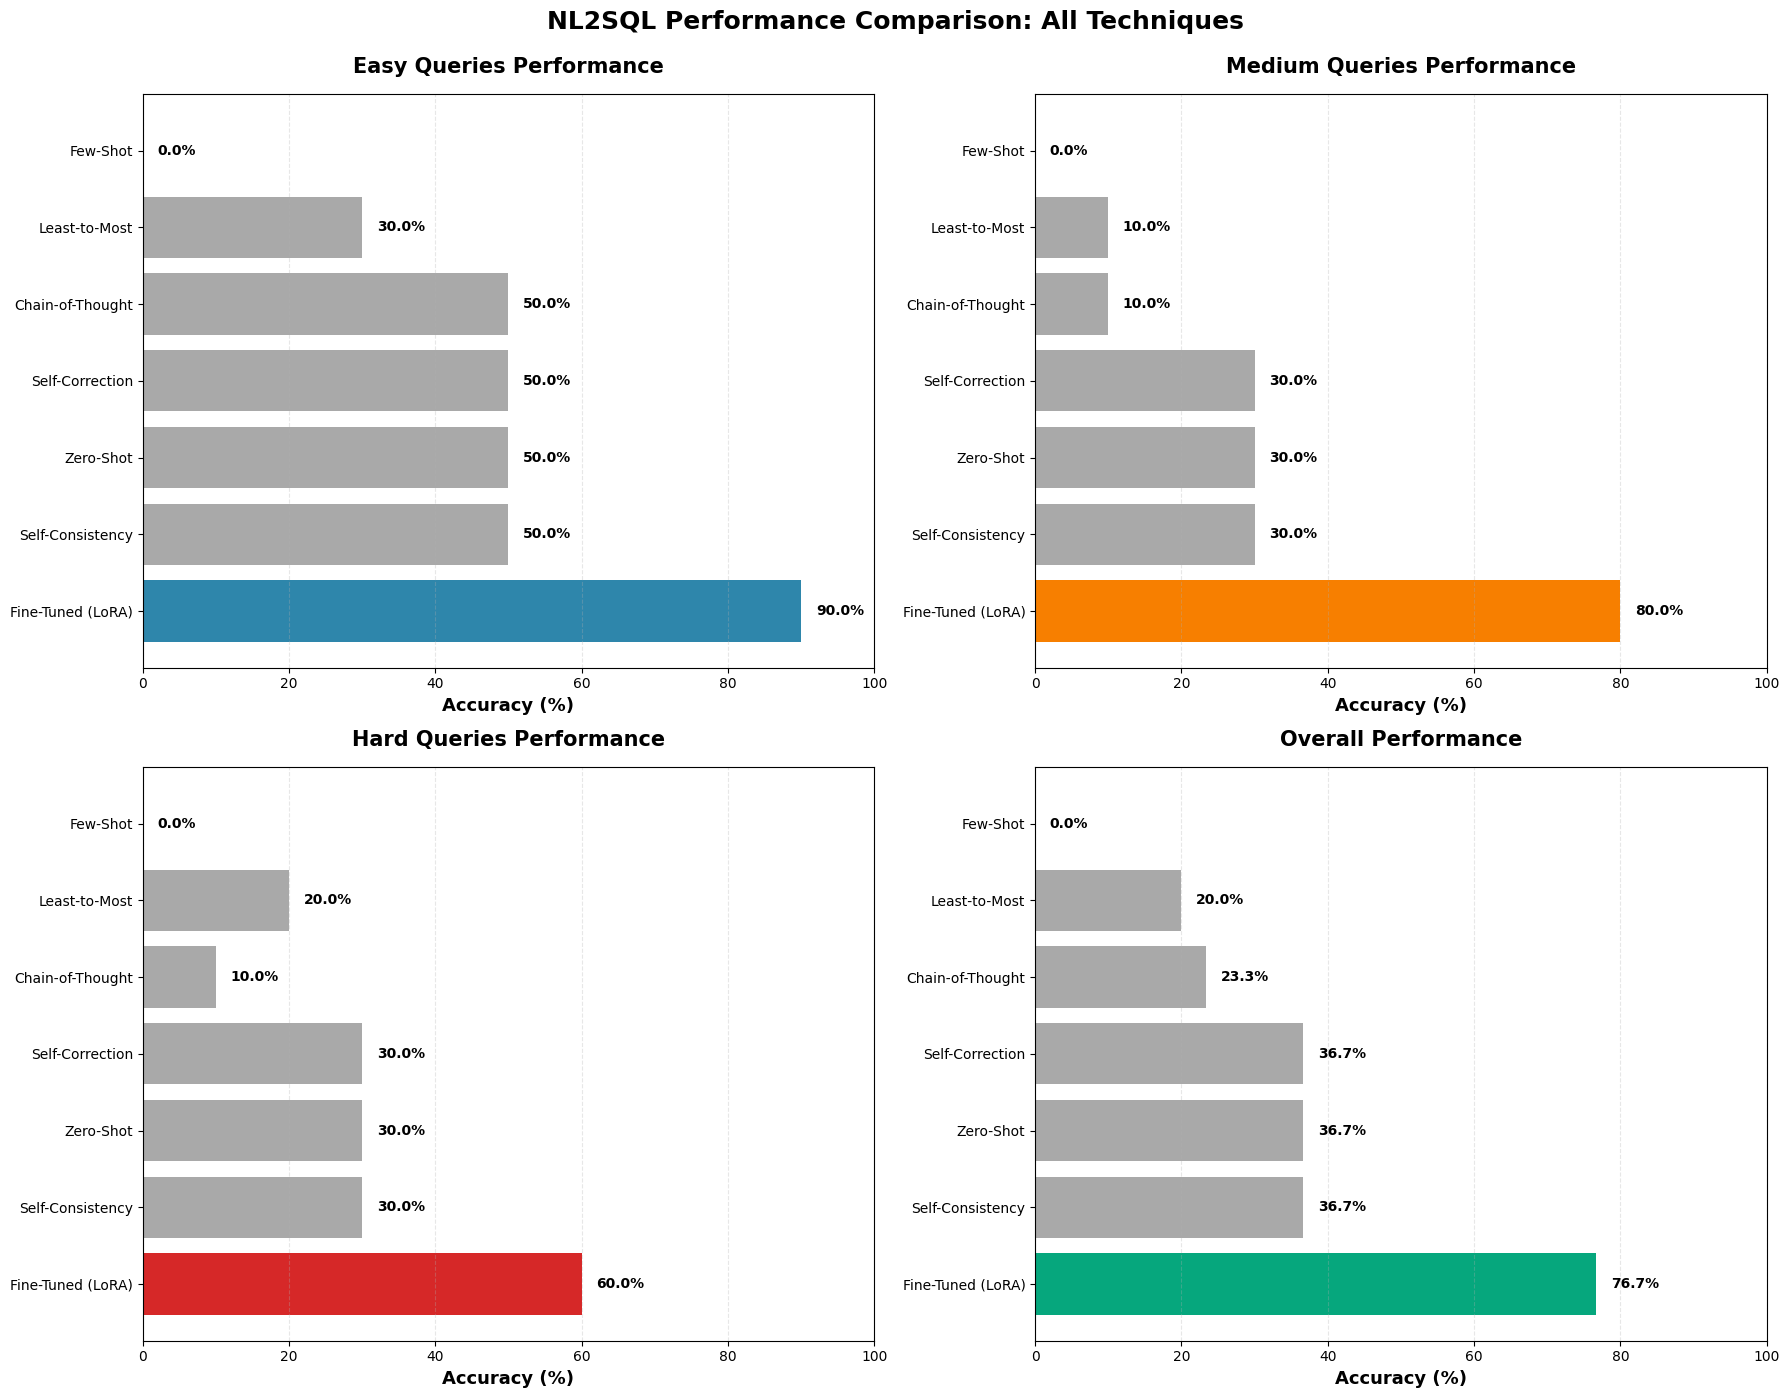

Visualization complete


In [ ]:
# Visualize comparison
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
techniques_list = df_final.index.tolist()
easy_scores = df_final['Easy'].tolist()
medium_scores = df_final['Medium'].tolist()
hard_scores = df_final['Hard'].tolist()
overall_scores = df_final['Overall'].tolist()

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Easy queries
colors_easy = ['#2E86AB' if t == 'Fine-Tuned (LoRA)' else '#A9A9A9' for t in techniques_list]
axes[0, 0].barh(techniques_list, easy_scores, color=colors_easy)
axes[0, 0].set_xlabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Easy Queries Performance', fontsize=15, fontweight='bold', pad=15)
axes[0, 0].set_xlim(0, 100)
axes[0, 0].grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(easy_scores):
    axes[0, 0].text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold')

# Medium queries
colors_medium = ['#F77F00' if t == 'Fine-Tuned (LoRA)' else '#A9A9A9' for t in techniques_list]
axes[0, 1].barh(techniques_list, medium_scores, color=colors_medium)
axes[0, 1].set_xlabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[0, 1].set_title('Medium Queries Performance', fontsize=15, fontweight='bold', pad=15)
axes[0, 1].set_xlim(0, 100)
axes[0, 1].grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(medium_scores):
    axes[0, 1].text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold')

# Hard queries
colors_hard = ['#D62828' if t == 'Fine-Tuned (LoRA)' else '#A9A9A9' for t in techniques_list]
axes[1, 0].barh(techniques_list, hard_scores, color=colors_hard)
axes[1, 0].set_xlabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[1, 0].set_title('Hard Queries Performance', fontsize=15, fontweight='bold', pad=15)
axes[1, 0].set_xlim(0, 100)
axes[1, 0].grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(hard_scores):
    axes[1, 0].text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold')

# Overall performance
colors_overall = ['#06A77D' if t == 'Fine-Tuned (LoRA)' else '#A9A9A9' for t in techniques_list]
axes[1, 1].barh(techniques_list, overall_scores, color=colors_overall)
axes[1, 1].set_xlabel('Accuracy (%)', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Overall Performance', fontsize=15, fontweight='bold', pad=15)
axes[1, 1].set_xlim(0, 100)
axes[1, 1].grid(axis='x', alpha=0.3, linestyle='--')
for i, v in enumerate(overall_scores):
    axes[1, 1].text(v + 2, i, f'{v:.1f}%', va='center', fontweight='bold')

plt.suptitle('NL2SQL Performance Comparison: All Techniques', fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print('Visualization complete')

---
## Part 15: Interactive Gradio UI

Launch an interactive interface to test all techniques in real-time!

In [ ]:
!pip install gradio plotly seaborn --break-system-packages --quiet

import gradio as gr
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import time
from typing import Optional, Tuple
import warnings
warnings.filterwarnings('ignore')

# =========================================================
# Enhanced Bridge Class with Your Functions Integration
# =========================================================
class NL2SQLInsightBridge:
    """Professional bridge that integrates with your existing notebook functions"""

    TECHNIQUES = [
        "auto",
        "rag",
        "zero_shot",
        "few_shot",
        "cot",
        "self_consistency",
        "self_correction",
        "least_to_most",
        "self_correction_rag",
    ]

    def __init__(self):
        self.g = globals()
        print("Bridge initialized")
        print(f"Available functions: {self._get_available_functions()}")

    def _get_available_functions(self):
        """Get list of available functions"""
        functions = []
        function_names = [
            'gen', 'exe', 'conn', 'SCHEMA', 'rag_generate_sql',
            'zero_shot', 'few_shot', 'cot', 'self_consistency',
            'self_correction', 'least_to_most'
        ]
        for name in function_names:
            if name in self.g:
                functions.append(name)
        return functions

    def _fn(self, names):
        """Find function by name"""
        for n in names:
            if n in self.g and callable(self.g[n]):
                return self.g[n]
        return None

    def _var(self, names):
        """Find variable by name"""
        for n in names:
            if n in self.g:
                return self.g[n]
        return None

    def db_health(self):
        """Check database connection health"""
        conn = self._var(["conn", "connection", "db_conn"])
        if conn is None:
            return False, "No connection object found"
        try:
            result = conn.execute("SELECT 1").fetchone()
            if result:
                return True, "Database connection OK"
            return False, "Database query returned no result"
        except Exception as e:
            return False, f"Database health check failed: {str(e)}"

    def recommend_method(self, q: str):
        """Recommend best method for the question"""
        q = (q or "").lower()
        if any(k in q for k in [" group", " top", " rank", " by ", " per "]):
            return "rag", "Grouping/aggregation query - RAG recommended"
        if any(k in q for k in ["trend", "month", "quarter", "over time", "daily", "weekly", "year"]):
            return "few_shot", "Temporal analysis - few-shot recommended"
        if any(k in q for k in ["average", "sum", "count", "min", "max", "median"]):
            return "zero_shot", "Simple aggregation - zero-shot sufficient"
        if any(k in q for k in ["why", "explain", "reason"]):
            return "cot", "Reasoning query - chain-of-thought recommended"
        return "rag", "Default recommendation"

    def _clean_sql(self, sql):
        """Clean SQL output from model"""
        if not sql or not isinstance(sql, str):
            return sql

        # Remove markdown code blocks
        sql = sql.strip()
        if sql.startswith('```sql'):
            sql = sql[6:]
        if sql.startswith('```'):
            sql = sql[3:]
        if sql.endswith('```'):
            sql = sql[:-3]

        # Remove trailing semicolons
        sql = sql.rstrip(';').strip()

        return sql

    def _gen_once(self, question: str, method: str):
        """Generate SQL using specified method"""
        try:
            # Direct technique functions
            if method == "zero_shot":
                fn = self._fn(["zero_shot"])
                if fn:
                    result = fn(question)
                    if isinstance(result, tuple) and len(result) >= 2:
                        sql, attempts = result[0], result[1]
                        return {"success": True, "sql": self._clean_sql(sql), "method": "zero_shot", "attempts": attempts, "explanation": "Zero-shot prompting"}

            elif method == "few_shot":
                fn = self._fn(["few_shot"])
                if fn:
                    result = fn(question)
                    if isinstance(result, tuple) and len(result) >= 2:
                        sql, attempts = result[0], result[1]
                        return {"success": True, "sql": self._clean_sql(sql), "method": "few_shot", "attempts": attempts, "explanation": "Few-shot prompting with examples"}

            elif method == "cot":
                fn = self._fn(["cot"])
                if fn:
                    result = fn(question)
                    if isinstance(result, tuple) and len(result) >= 2:
                        sql, attempts = result[0], result[1]
                        return {"success": True, "sql": self._clean_sql(sql), "method": "chain_of_thought", "attempts": attempts, "explanation": "Chain-of-thought reasoning"}

            elif method == "self_consistency":
                fn = self._fn(["self_cons", "self_consistency"])
                if fn:
                    result = fn(question)
                    if isinstance(result, tuple) and len(result) >= 2:
                        sql, attempts = result[0], result[1]
                        return {"success": True, "sql": self._clean_sql(sql), "method": "self_consistency", "attempts": attempts, "explanation": "Self-consistency prompting"}

            elif method == "self_correction":
                fn = self._fn(["self_corr", "self_correction"])
                if fn:
                    result = fn(question)
                    if isinstance(result, tuple) and len(result) >= 2:
                        sql, attempts = result[0], result[1]
                        return {"success": True, "sql": self._clean_sql(sql), "method": "self_correction", "attempts": attempts, "explanation": "Self-correction prompting"}

            elif method == "least_to_most":
                fn = self._fn(["ltm", "least_to_most"])
                if fn:
                    result = fn(question)
                    if isinstance(result, tuple) and len(result) >= 2:
                        sql, attempts = result[0], result[1]
                        return {"success": True, "sql": self._clean_sql(sql), "method": "least_to_most", "attempts": attempts, "explanation": "Least-to-most prompting"}

            # RAG method
            elif method == "rag":
                rag_fn = self._fn(["rag_generate_sql", "rag_generate"])
                if rag_fn:
                    result = rag_fn(question)
                    if isinstance(result, dict):
                        sql = result.get("sql", result.get("query", str(result)))
                        return {"success": True, "sql": self._clean_sql(sql), "method": "rag", "explanation": "RAG with retrieved examples"}
                    elif isinstance(result, tuple) and len(result) >= 2:
                        sql, attempts = result[0], result[1]
                        return {"success": True, "sql": self._clean_sql(sql), "method": "rag", "attempts": attempts, "explanation": "RAG with retrieved examples"}
                    elif isinstance(result, str):
                        return {"success": True, "sql": self._clean_sql(result), "method": "rag", "explanation": "RAG with retrieved examples"}

            # Fallback to baseline gen function
            gen_fn = self._fn(["gen", "generate_sql"])
            schema = self._var(["SCHEMA", "schema"])
            if gen_fn and schema:
                prompt = f"{schema}\n\n### Question: {question}\n### SQL:"
                sql = gen_fn(prompt)
                return {"success": True, "sql": self._clean_sql(sql), "method": method, "attempts": 1, "explanation": f"{method} via baseline generation"}

            raise RuntimeError(f"No function available for method: {method}")

        except Exception as e:
            print(f"Error in _gen_once for {method}: {str(e)}")
            raise e

    def generate_sql(self, question: str, method: str = "auto"):
        """Generate SQL with automatic method selection"""
        start = time.time()

        if method != "auto":
            try:
                result = self._gen_once(question, method)
                result["elapsed_s"] = time.time() - start
                return result
            except Exception as e:
                return {"success": False, "sql": f"-- Error: {str(e)}", "method": method, "elapsed_s": time.time() - start, "explanation": f"Error: {str(e)}"}

        # Auto method selection
        primary, reason = self.recommend_method(question)
        tried = []

        # Try methods in order of preference
        methods_to_try = [primary, "rag", "few_shot", "zero_shot", "cot"]

        for m in methods_to_try:
            if m in tried:
                continue
            tried.append(m)
            try:
                result = self._gen_once(question, m)
                result.update({
                    "elapsed_s": time.time() - start,
                    "auto_reason": reason,
                    "auto_tried": tried
                })
                return result
            except Exception as e:
                print(f"Method {m} failed: {str(e)}")
                continue

        return {
            "success": False,
            "sql": "-- No method succeeded",
            "method": "auto",
            "elapsed_s": time.time() - start,
            "auto_reason": reason,
            "auto_tried": tried
        }

    def execute_sql(self, sql: str):
        """Execute SQL with validation and error handling"""
        start = time.time()

        try:
            # First validate with exe function if available
            exe_fn = self._fn(["exe", "execute_sql"])
            if exe_fn:
                print(f"Validating SQL: {sql[:100]}...")
                is_valid = exe_fn(sql)
                if not is_valid:
                    return {
                        "success": False,
                        "data": pd.DataFrame(),
                        "rows": 0,
                        "columns": [],
                        "elapsed_s": time.time() - start,
                        "message": "SQL validation failed"
                    }

            # Execute with connection
            conn = self._var(["conn", "connection", "db_conn"])
            if not conn:
                return {
                    "success": False,
                    "data": pd.DataFrame(),
                    "rows": 0,
                    "columns": [],
                    "elapsed_s": time.time() - start,
                    "message": "No database connection available"
                }

            print(f"Executing SQL...")

            # Try pandas first
            try:
                df = pd.read_sql_query(sql, conn)
                print(f"Pandas execution successful, got {len(df)} rows")
                return {
                    "success": True,
                    "data": df,
                    "rows": len(df),
                    "columns": list(df.columns),
                    "elapsed_s": time.time() - start,
                    "message": f"Successfully retrieved {len(df)} rows"
                }
            except Exception as e1:
                print(f"Pandas failed: {e1}, trying direct execution...")

            # Fallback to direct execution
            try:
                result = conn.execute(sql)
                rows = result.fetchall()

                # Get column names
                try:
                    # Try to get column info using DESCRIBE
                    desc_result = conn.execute(f"DESCRIBE ({sql})")
                    columns = [row[0] for row in desc_result.fetchall()]
                except:
                    # Fallback to generic column names
                    if rows and len(rows) > 0:
                        columns = [f"col_{i}" for i in range(len(rows[0]))]
                    else:
                        columns = []

                df = pd.DataFrame(rows, columns=columns)
                print(f"Direct execution successful, got {len(df)} rows")

                return {
                    "success": True,
                    "data": df,
                    "rows": len(df),
                    "columns": list(df.columns),
                    "elapsed_s": time.time() - start,
                    "message": f"Successfully retrieved {len(df)} rows"
                }
            except Exception as e2:
                print(f"Direct execution failed: {e2}")
                return {
                    "success": False,
                    "data": pd.DataFrame(),
                    "rows": 0,
                    "columns": [],
                    "elapsed_s": time.time() - start,
                    "message": f"Execution failed: {str(e2)}"
                }

        except Exception as e:
            print(f"Execute_sql error: {str(e)}")
            return {
                "success": False,
                "data": pd.DataFrame(),
                "rows": 0,
                "columns": [],
                "elapsed_s": time.time() - start,
                "message": f"Error: {str(e)}"
            }

    def _create_placeholder_fig(self, title="No data"):
        """Create placeholder figure"""
        fig = go.Figure()
        fig.add_annotation(
            text=title,
            x=0.5, y=0.5,
            xref="paper", yref="paper",
            showarrow=False,
            font=dict(size=16, color="gray")
        )
        fig.update_xaxes(visible=False)
        fig.update_yaxes(visible=False)
        fig.update_layout(height=400, showlegend=False)
        return fig

    def generate_insights(self, df: pd.DataFrame, question: str, sql: str):
        """Generate comprehensive insights and visualizations"""
        insights = {
            "summary": {},
            "visualizations": [],
            "key_findings": [],
            "recommendations": []
        }

        if df is None or df.empty:
            insights["summary"] = {"message": "No data to analyze"}
            insights["key_findings"].append("No rows returned from query")
            insights["recommendations"].extend([
                "Check your WHERE conditions",
                "Verify table and column names",
                "Try removing filters to see if data exists"
            ])
            insights["visualizations"].append({
                "type": "placeholder",
                "figure": self._create_placeholder_fig("No data returned")
            })
            return insights

        try:
            # Summary statistics
            insights["summary"] = {
                "total_rows": len(df),
                "total_columns": len(df.columns),
                "memory_kb": round(df.memory_usage(deep=True).sum() / 1024, 2),
                "data_types": {str(col): str(dtype) for col, dtype in df.dtypes.items()}
            }

            # Data type categorization
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            categorical_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
            datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

            print(f"Data analysis: {len(numeric_cols)} numeric, {len(categorical_cols)} categorical, {len(datetime_cols)} datetime columns")

            # Create visualizations based on data structure
            if len(df.columns) == 1:
                col = df.columns[0]
                if col in numeric_cols:
                    fig = px.histogram(df, x=col, title=f"Distribution of {col}")
                    insights["visualizations"].append({"type": "histogram", "figure": fig})
                else:
                    # Categorical single column
                    value_counts = df[col].value_counts().head(10)
                    if len(value_counts) > 0:
                        fig = px.bar(x=value_counts.index, y=value_counts.values,
                                   labels={'x': col, 'y': 'Count'}, title=f"Top 10 {col}")
                        insights["visualizations"].append({"type": "bar", "figure": fig})

            elif len(df.columns) == 2:
                col1, col2 = df.columns[0], df.columns[1]

                if col1 in numeric_cols and col2 in numeric_cols:
                    # Two numeric columns - scatter plot
                    fig = px.scatter(df, x=col1, y=col2, title=f"{col1} vs {col2}")
                    insights["visualizations"].append({"type": "scatter", "figure": fig})

                elif col1 in categorical_cols and col2 in numeric_cols:
                    # Categorical vs Numeric - bar chart
                    # Limit to top 15 categories for readability
                    top_cats = df[col1].value_counts().head(15).index
                    df_filtered = df[df[col1].isin(top_cats)]
                    fig = px.bar(df_filtered, x=col1, y=col2, title=f"{col2} by {col1}")
                    insights["visualizations"].append({"type": "bar", "figure": fig})

                elif col1 in numeric_cols and col2 in categorical_cols:
                    # Numeric vs Categorical - horizontal bar chart
                    top_cats = df[col2].value_counts().head(15).index
                    df_filtered = df[df[col2].isin(top_cats)]
                    fig = px.bar(df_filtered, x=col1, y=col2, orientation='h', title=f"{col1} by {col2}")
                    insights["visualizations"].append({"type": "bar", "figure": fig})

                else:
                    # Two categorical columns - show distribution of first
                    value_counts = df[col1].value_counts().head(10)
                    if len(value_counts) > 0:
                        fig = px.pie(values=value_counts.values, names=value_counts.index,
                                   title=f"Distribution of {col1}")
                        insights["visualizations"].append({"type": "pie", "figure": fig})

            else:
                # Multiple columns
                if len(numeric_cols) > 1:
                    # Correlation matrix for numeric columns
                    try:
                        corr_matrix = df[numeric_cols].corr()
                        fig = px.imshow(corr_matrix, text_auto=True, aspect="auto",
                                      title="Correlation Matrix")
                        insights["visualizations"].append({"type": "heatmap", "figure": fig})
                    except Exception as e:
                        print(f"Correlation matrix failed: {e}")

                # Distribution of categorical columns
                for col in categorical_cols[:2]:  # Limit to first 2 categorical columns
                    try:
                        value_counts = df[col].value_counts().head(10)
                        if len(value_counts) > 0:
                            fig = px.pie(values=value_counts.values, names=value_counts.index,
                                       title=f"Distribution of {col}")
                            insights["visualizations"].append({"type": "pie", "figure": fig})
                    except Exception as e:
                        print(f"Pie chart for {col} failed: {e}")

            # Generate key findings
            insights["key_findings"].append(f"Dataset: {len(df):,} rows, {len(df.columns)} columns")

            # Numeric column insights
            for col in numeric_cols[:3]:
                try:
                    if not df[col].isna().all():
                        min_val, max_val, mean_val = df[col].min(), df[col].max(), df[col].mean()
                        insights["key_findings"].append(f"{col}: Range {min_val:.2f} to {max_val:.2f}, Average {mean_val:.2f}")
                except Exception as e:
                    print(f"Numeric analysis for {col} failed: {e}")

            # Categorical column insights
            for col in categorical_cols[:2]:
                try:
                    unique_count = df[col].nunique()
                    if not df[col].mode().empty:
                        most_common = df[col].mode().iloc[0]
                        insights["key_findings"].append(f"{col}: {unique_count} unique values, most common: '{most_common}'")
                except Exception as e:
                    print(f"Categorical analysis for {col} failed: {e}")

            # Data quality insights
            null_counts = df.isnull().sum()
            if null_counts.sum() > 0:
                insights["key_findings"].append(f"Missing data in {(null_counts > 0).sum()} columns")
            else:
                insights["key_findings"].append("No missing data detected")

            # Generate recommendations
            if len(df) > 10000:
                insights["recommendations"].append("Large dataset - consider adding LIMIT for faster queries")

            if len(numeric_cols) > 1:
                insights["recommendations"].append("Multiple numeric columns - correlation analysis available")

            if "ORDER BY" not in sql.upper():
                insights["recommendations"].append("Consider adding ORDER BY for consistent results")

            if "GROUP BY" in sql.upper():
                insights["recommendations"].append("Grouped data detected - good for aggregation visualizations")

            # Add visualization if none were created
            if not insights["visualizations"]:
                insights["visualizations"].append({
                    "type": "placeholder",
                    "figure": self._create_placeholder_fig("No suitable visualization found")
                })

        except Exception as e:
            print(f"Insights generation error: {str(e)}")
            insights["summary"]["error"] = f"Error generating insights: {str(e)}"
            insights["visualizations"].append({
                "type": "placeholder",
                "figure": self._create_placeholder_fig("Error generating visualization")
            })

        return insights

    def get_schema_info(self):
        """Get database schema information"""
        schema = self._var(["SCHEMA", "schema"])
        if schema:
            return schema

        # Fallback: try to get schema from database
        conn = self._var(["conn", "connection", "db_conn"])
        if conn:
            try:
                # Try to get table info from DuckDB
                tables_result = conn.execute("SHOW TABLES").fetchall()
                schema_text = "### Database Tables:\n"
                for table in tables_result:
                    table_name = table[0]
                    schema_text += f"\n{table_name}:\n"
                    try:
                        cols_result = conn.execute(f"DESCRIBE {table_name}").fetchall()
                        for col_info in cols_result:
                            schema_text += f"  - {col_info[0]} ({col_info[1]})\n"
                    except:
                        schema_text += "  - (columns not accessible)\n"
                return schema_text
            except:
                pass

        return "Schema information not available"

    def process_nl_query(self, question: str, method: str = "auto"):
        """Complete end-to-end query processing"""
        print(f"\nProcessing query with method: {method}")

        # Step 1: Generate SQL
        sql_result = self.generate_sql(question, method)
        if not sql_result.get("success"):
            return {
                "question": question,
                "method": method,
                "sql_generation": sql_result,
                "execution": {"success": False, "message": "SQL generation failed"},
                "insights": {"summary": {"message": "No insights available"}},
                "overall_success": False
            }

        # Step 2: Execute SQL
        execution_result = self.execute_sql(sql_result["sql"])
        if not execution_result.get("success"):
            return {
                "question": question,
                "method": method,
                "sql_generation": sql_result,
                "execution": execution_result,
                "insights": {"summary": {"message": "No insights available"}},
                "overall_success": False
            }

        # Step 3: Generate insights
        insights = self.generate_insights(execution_result["data"], question, sql_result["sql"])

        return {
            "question": question,
            "method": method,
            "sql_generation": sql_result,
            "execution": execution_result,
            "insights": insights,
            "overall_success": True
        }

# Initialize the bridge
bridge = NL2SQLInsightBridge()

# =========================================================
# Curated Query Library for Your Olist Dataset
# =========================================================
QUERY_LIBRARY = {
    "Orders & Sales Trends": [
        "Show the number of orders per month in 2018",
        "Show monthly revenue trends",
        "Show total orders by customer state",
        "Show average order value by month",
    ],
    "Customers & Demographics": [
        "Show top 10 states by number of customers",
        "Show customer distribution by city",
        "Show average orders per customer",
        "Show new customers by month",
    ],
    "Products & Categories": [
        "Show top 10 product categories by revenue",
        "Show average product price by category",
        "Show number of products per category",
        "Show best selling products",
    ],
    "Payments & Revenue": [
        "Show payment method distribution",
        "Show average payment value by payment type",
        "Show revenue by payment installments",
        "Show monthly payment trends",
    ],
    "Delivery & Logistics": [
        "Show average delivery time by state",
        "Show freight cost by customer state",
        "Show delivery performance metrics",
        "Show late deliveries by month",
    ],
    "Reviews & Satisfaction": [
        "Show average review score by product category",
        "Show review score distribution",
        "Show monthly review trends",
        "Show review scores by delivery time",
    ],
}

# =========================================================
# Gradio Interface Functions
# =========================================================
def process_query(question: str, method: str, include_insights: bool):
    """Main query processing function for Gradio"""
    if not question.strip():
        return (
            "Please enter a question",
            "-- No SQL generated",
            pd.DataFrame(),
            "No data available",
            bridge._create_placeholder_fig("No data"),
            "Please provide a question to analyze"
        )

    try:
        # Process the complete query
        result = bridge.process_nl_query(question, method)

        sql_gen = result["sql_generation"]
        execution = result["execution"]
        insights = result["insights"]

        # Database health check
        db_ok, db_msg = bridge.db_health()
        db_status = f"Database: {db_msg}" if db_ok else f"Database Error: {db_msg}"

        # Format status message
        if result["overall_success"]:
            auto_info = ""
            if method == "auto" and "auto_reason" in sql_gen:
                auto_info = f"\nAuto-selected: {sql_gen['method']} ({sql_gen['auto_reason']})"

            status_msg = f"""{db_status}

**Query Successful**
Method: {sql_gen.get('method', method)}{auto_info}
Generation: {sql_gen.get('elapsed_s', 0):.2f}s
Execution: {execution.get('elapsed_s', 0):.2f}s
Rows: {execution.get('rows', 0):,}
{sql_gen.get('explanation', 'Query processed successfully')}"""
        else:
            status_msg = f"""{db_status}

**Query Failed**
Method: {sql_gen.get('method', method)}
SQL Generation: {'Success' if sql_gen.get('success') else 'Failed'}
Execution: {'Success' if execution.get('success') else 'Failed'}
Error: {execution.get('message', 'Unknown error')}

**Troubleshooting:**
- Check if all notebook cells have been run
- Verify database connection is active
- Try a simpler version of your query"""

        # Get SQL and data
        sql_query = sql_gen.get("sql", "-- No SQL generated")
        data_df = execution.get("data", pd.DataFrame())

        # Format execution summary
        if execution.get("success") and not data_df.empty:
            preview = data_df.head(5).to_string(index=False) if len(data_df) > 0 else "No data"
            exec_summary = f"""**Execution Successful**

**Results Summary:**
- Rows: {execution.get('rows', 0):,}
- Columns: {', '.join(execution.get('columns', []))}
- Processing Time: {execution.get('elapsed_s', 0):.3f}s

**Data Preview:**
```
{preview}
```"""
        else:
            exec_summary = f"""**Execution Failed**

**Error:** {execution.get('message', 'Unknown error')}

**Common Solutions:**
- Check table and column names in your query
- Verify your database connection is working
- Try removing complex WHERE conditions
- Test with a simpler query first"""

        # Generate visualization
        plot = bridge._create_placeholder_fig("No data")
        if include_insights and not data_df.empty and insights.get("visualizations"):
            try:
                viz = insights["visualizations"][0]
                plot = viz["figure"]
                print("Visualization created successfully")
            except Exception as e:
                print(f"Visualization error: {e}")
                plot = bridge._create_placeholder_fig("Visualization error")

        # Format insights text
        if include_insights and insights:
            insights_text = f"""# **Comprehensive Query Analysis**

## **Data Summary**
- Total Records: {insights['summary'].get('total_rows', 0):,}
- Columns: {insights['summary'].get('total_columns', 0)}
- Memory Usage: {insights['summary'].get('memory_kb', 'N/A')} KB

## **Key Findings**
"""

            for finding in insights.get("key_findings", []):
                insights_text += f"- {finding}\n"

            if not insights.get("key_findings"):
                insights_text += "- No specific findings available\n"

            insights_text += "\n## **Recommendations**\n"
            for rec in insights.get("recommendations", []):
                insights_text += f"- {rec}\n"

            if not insights.get("recommendations"):
                insights_text += "- No specific recommendations\n"

            viz_count = len(insights.get("visualizations", []))
            viz_types = [v.get("type", "unknown") for v in insights.get("visualizations", [])]
            insights_text += f"""
## **Visualizations**
- Count: {viz_count}
- Types: {', '.join(viz_types) if viz_types else 'None'}"""
        else:
            insights_text = """# **Query Analysis**

**Insights disabled.** Enable "Include Insights and Visualizations" to see:
- Data summaries and statistics
- Automatic visualizations
- Key findings and patterns
- Actionable recommendations"""

        return (status_msg, sql_query, data_df, exec_summary, plot, insights_text)

    except Exception as e:
        print(f"Unexpected error in process_query: {str(e)}")
        import traceback
        traceback.print_exc()

        error_msg = f"""**Unexpected Error**

Error: {str(e)}

Please try:
- Restarting the notebook kernel
- Running all cells again
- Checking the debug output below"""

        return (
            error_msg,
            f"-- Error: {str(e)}",
            pd.DataFrame(),
            f"Processing failed: {str(e)}",
            bridge._create_placeholder_fig("Error"),
            f"**Error Details:** {str(e)}"
        )

def get_schema_markdown():
    """Get formatted schema information"""
    schema_text = bridge.get_schema_info()
    return f"""# **Database Schema**

```sql
{schema_text}
```

**Query Tips:**
- Use exact table and column names from the schema above
- Join related tables using appropriate keys
- Use aggregate functions (COUNT, SUM, AVG) for summaries
- Add WHERE clauses to filter results
- Use ORDER BY for sorted results"""

def on_category_change(category_name):
    """Update query dropdown when category changes"""
    if category_name and category_name in QUERY_LIBRARY:
        options = QUERY_LIBRARY[category_name]
        return gr.update(choices=options, value=options[0] if options else None)
    return gr.update(choices=[], value=None)

def push_to_query_page(selected_query):
    """Send selected query to main query page"""
    if selected_query:
        return selected_query, "auto", True
    return "", "auto", True

def get_db_status():
    """Get current database status"""
    ok, msg = bridge.db_health()
    color = "#16a34a" if ok else "#dc2626"
    status_icon = "Connected" if ok else "Error"
    return f"""<div style="padding: 10px; border-radius: 5px; background-color: {'#f0f9ff' if ok else '#fef2f2'};">
<strong>Database Status:</strong>
<span style="color: {color}; font-weight: bold;">{status_icon}</span>
<br><small>{msg}</small>
</div>"""

# =========================================================
# Create Gradio Interface
# =========================================================
with gr.Blocks(
    title="NL2SQL Intelligent Data Assistant",
    theme=gr.themes.Soft(),
    css="""
    .main-header {
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 24px;
        border-radius: 10px;
        margin-bottom: 24px;
        text-align: center;
    }
    .status-box {
        padding: 15px;
        border-radius: 8px;
        margin: 10px 0;
    }
    .success { background-color: #f0f9ff; border-left: 4px solid #3b82f6; }
    .error { background-color: #fef2f2; border-left: 4px solid #ef4444; }
    """
) as interface:

    # Header
    gr.HTML("""
    <div class="main-header">
        <h1>NL2SQL Intelligent Data Assistant</h1>
        <p>Transform natural language questions into SQL queries and gain instant insights from your data</p>
    </div>
    """)

    with gr.Tabs():

        # Tab 1: Main Query Interface
        with gr.Tab("Query & Analyze"):

            with gr.Row():
                with gr.Column(scale=2):
                    question_input = gr.Textbox(
                        label="Ask your question in natural language",
                        placeholder="e.g., Show the number of orders per month in 2018",
                        lines=3
                    )

                    with gr.Row():
                        method_dropdown = gr.Dropdown(
                            choices=NL2SQLInsightBridge.TECHNIQUES,
                            value="auto",
                            label="Generation Method",
                            info="Auto mode automatically selects the best method for your query"
                        )

                        insights_checkbox = gr.Checkbox(
                            label="Include Insights & Visualizations",
                            value=True,
                            info="Generate charts and detailed analysis"
                        )

                    submit_btn = gr.Button("Analyze Query", variant="primary", size="lg")

                with gr.Column(scale=1):
                    db_status_display = gr.HTML(label="Database Status")
                    status_output = gr.Markdown(label="Processing Status")

            # SQL Output
            with gr.Row():
                sql_output = gr.Code(label="Generated SQL Query", language="sql", lines=3)

            # Results Section
            with gr.Row():
                with gr.Column(scale=2):
                    data_output = gr.Dataframe(
                        label="Query Results",
                        interactive=False,
                        wrap=True
                    )

                with gr.Column(scale=1):
                    execution_output = gr.Markdown(label="Execution Summary")

            # Insights Section
            with gr.Row():
                with gr.Column():
                    plot_output = gr.Plot(label="Data Visualization")

                with gr.Column():
                    insights_output = gr.Markdown(label="Insights & Analysis")

        # Tab 2: Database Schema
        with gr.Tab("Database Schema"):
            schema_info = gr.Markdown(value=get_schema_markdown())

        # Tab 3: Query Library
        with gr.Tab("Query Library"):
            gr.Markdown("""
            ### **Curated Query Examples**

            Browse pre-built queries organized by category. These queries are designed to work with your Olist e-commerce dataset and demonstrate various analytical approaches.

            **How to use:**
            1. Select a category below
            2. Choose a specific query
            3. Click "Send to Query Page" to populate the main interface
            """)

            with gr.Row():
                category_dropdown = gr.Dropdown(
                    choices=list(QUERY_LIBRARY.keys()),
                    value=list(QUERY_LIBRARY.keys())[0],
                    label="Category",
                    info="Choose a query category"
                )

                query_dropdown = gr.Dropdown(
                    choices=QUERY_LIBRARY[list(QUERY_LIBRARY.keys())[0]],
                    value=QUERY_LIBRARY[list(QUERY_LIBRARY.keys())[0]][0],
                    label="Query",
                    info="Select a specific query"
                )

            send_button = gr.Button("Send to Query Page", variant="secondary")

            # Example categories info
            gr.Markdown("""
            ### **Available Categories:**

            - **Orders & Sales Trends:** Revenue analysis, monthly trends, geographical distribution
            - **Customers & Demographics:** Customer segmentation, geographical analysis, behavior patterns
            - **Products & Categories:** Product performance, category analysis, pricing insights
            - **Payments & Revenue:** Payment method analysis, installment patterns, revenue trends
            - **Delivery & Logistics:** Shipping performance, delivery times, freight analysis
            - **Reviews & Satisfaction:** Customer satisfaction, review patterns, quality metrics
            """)

        # Tab 4: Method Comparison
        with gr.Tab("Method Comparison"):
            gr.Markdown("""
            # **AI Generation Methods Explained**

            ## **Auto Mode (Recommended)**
            - **What it does:** Automatically selects the best method based on your question
            - **Best for:** All users, especially beginners
            - **Pros:** Intelligent selection, optimal results, no method knowledge required

            ## **Method Details**

            ### **RAG (Retrieval-Augmented Generation)**
            - **How it works:** Uses relevant examples from your knowledge base
            - **Best for:** Complex business queries, domain-specific questions
            - **Example:** "Show customer lifetime value by segment"

            ### **Zero-Shot**
            - **How it works:** Generates SQL directly without examples
            - **Best for:** Simple counting, basic aggregations
            - **Example:** "How many customers are there?"

            ### **Few-Shot**
            - **How it works:** Uses predefined examples to guide generation
            - **Best for:** Standard analytical patterns
            - **Example:** "Show top 10 products by sales"

            ### **Chain-of-Thought (CoT)**
            - **How it works:** Breaks down complex problems step-by-step
            - **Best for:** Multi-step reasoning, complex logic
            - **Example:** "Compare Q1 vs Q2 performance across regions"

            ### **Self-Consistency**
            - **How it works:** Generates multiple solutions and picks the best
            - **Best for:** When accuracy is critical
            - **Trade-off:** Slower but more reliable

            ### **Self-Correction**
            - **How it works:** Iteratively improves SQL based on validation
            - **Best for:** Complex queries with potential syntax issues
            - **Trade-off:** Multiple attempts for better accuracy

            ## **Usage Recommendations**

            1. **Start with Auto** - let the system choose for you
            2. **Try RAG** for complex business questions
            3. **Use Zero-Shot** for quick, simple queries
            4. **Switch methods** if you're not getting good results
            5. **Compare results** across different methods for critical queries
            """)

    # Event Handlers
    submit_btn.click(
        fn=process_query,
        inputs=[question_input, method_dropdown, insights_checkbox],
        outputs=[status_output, sql_output, data_output, execution_output, plot_output, insights_output]
    )

    category_dropdown.change(
        fn=on_category_change,
        inputs=[category_dropdown],
        outputs=[query_dropdown]
    )

    send_button.click(
        fn=push_to_query_page,
        inputs=[query_dropdown],
        outputs=[question_input, method_dropdown, insights_checkbox]
    )

    # Load database status on startup
    interface.load(
        fn=get_db_status,
        outputs=[db_status_display]
    )

    # Quick Examples Section
    with gr.Row():
        gr.Examples(
            examples=[
                ["Show the number of orders per month in 2018", "auto", True],
                ["Show top 10 product categories by revenue", "rag", True],
                ["Show customer distribution by state", "few_shot", True],
                ["What is the average order value?", "zero_shot", True],
                ["Show payment method trends over time", "cot", True]
            ],
            inputs=[question_input, method_dropdown, insights_checkbox],
            label="**Quick Start Examples** - Click any example to try it"
        )

# Launch Information
print("=" * 60)
print("NL2SQL Intelligent Data Assistant")
print("=" * 60)
print("Bridge initialized successfully")
print(f"Available methods: {', '.join(NL2SQLInsightBridge.TECHNIQUES)}")
print(f"Query library: {len(QUERY_LIBRARY)} categories")
print(f"Available functions: {bridge._get_available_functions()}")

# Test database connection
db_ok, db_msg = bridge.db_health()
print(f"Database: {'Connected' if db_ok else 'Error'} - {db_msg}")

print("\nLaunching Gradio interface...")
print("Use the Query Library tab for pre-built examples!")

try:
    interface.close()
except:
    pass

# Launch with automatic port selection
print("Launching with automatic port selection...")
interface.launch(
    share=True,
    debug=False,
    show_error=True,
    # Remove server_name and server_port to let Gradio auto-select
)

print("Interface launched successfully!")
print("Click the public URL above to access your NL2SQL application")
